## 💧 Unconditional Generation 

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

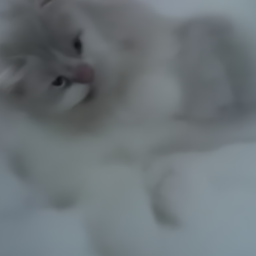

In [1]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True)
image = ddpm(num_inference_steps=25,).images[0]
image

### 🔬 look up the internal of pipeline

- 위에 실행했던 `ddpm` pipeline 은 아래와 같이 구성되어 있음 
    ```
    DDPMPipeline {
    "_class_name": "DDPMPipeline",
    "_diffusers_version": "0.26.1",
    "_name_or_path": "google/ddpm-cat-256",
    "scheduler": [
        "diffusers",
        "DDPMScheduler"
    ],
    "unet": [
        "diffusers",
        "UNet2DModel"
    ]
    }
    ```
- `UNet2DModel` , `DDPMScheduler` 의 구성요소를 기반으로 아래 denoising 과정을 구현한 것이 `ddmp` pipeline 임

   - `UNet2DModel` 과 `DDPMScheduler` 를 다운로드 받고 로딩

   - 몇 번에 걸쳐서 denoising 과정을 끝낼 것인지를 설정하기 위해 `DDPMScheduler` 의 `timesteps` 를 설정

   - `unet` 의 입력 크기에 맞는 초기 노이즈를 정규분포에서 생성

   - denoising 과정을 설정된 `timesteps` 만큼 반복 수행 

     - noise 를 model 에 주고 residual 을 예측

     - 예측된 residual 을 가지고 scheduler 가 이전 noise 를 예측, 이것을 다음 model 의 입력으로 설정

   - 마지막 `schduler` 의 출력값(텐서)를 가지고 PIL 형식에 맞는 이미지 생성 


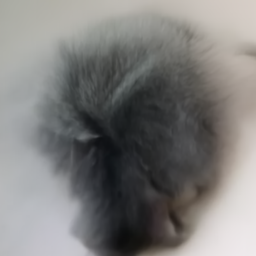

In [2]:
import torch
import numpy as np
from PIL import Image
from diffusers import UNet2DModel, DDPMScheduler

##############################################################################################################
# `UNet2DModel` 과 `DDPMScheduler` 를 다운로드 받고 로딩
##############################################################################################################
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256", use_safetensors=True)


##############################################################################################################
# 몇 번에 걸쳐서 denoising 과정을 끝낼 것인지를 설정하기 위해 `DDPMScheduler` 의 `timesteps` 를 설정
##############################################################################################################
scheduler.set_timesteps(25)

##############################################################################################################
# `unet` 의 입력 크기에 맞는 초기 노이즈를 정규분포에서 생성
##############################################################################################################
noise = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size).to("cuda")

##############################################################################################################
# denoising 과정을 설정된 `timesteps` 만큼 반복 수행 
##############################################################################################################
input = noise
for t in scheduler.timesteps:
    # noise 를 model 에 주고 residual 을 예측
    with torch.no_grad():
        residual = model(input, t).sample
    # 예측된 residual 을 가지고 scheduler 가 이전 noise 를 예측
    prev_sample = scheduler.step(model_output = residual, timestep = t, sample = input).prev_sample
    # 이것을 다음 model 의 입력으로 설정
    input = prev_sample

##############################################################################################################
# image 로 변환하여 출력
##############################################################################################################
# [-1, 1] 범위를 [0, 1] 로 스케일링
image = (input / 2 + 0.5).squeeze()
# channel 정보 위치를 변경하고 [0, 255] 사이의 unit8 로 변환하고 이를 cpu 로 넘긴 후 numpy 로 변환
image = (image.permute(1, 2, 0)*255).round().to(torch.uint8).cpu().numpy()
# PIL Image 로 변환
image = Image.fromarray(image)

image

## 💧 Conditional Generation 
### 🧪 Stable Diffusion 의 Pipeline 살펴보기 ([ref - stable diffusion with diffusers](https://huggingface.co/blog/stable_diffusion#how-does-stable-diffusion-work))

| 조정 가능 인자                  | 설명                                                                 |
|-----------------------------|--------------------------------------------------------------------|
| Tensor 의 정밀도 (Precision)       | 모델 연산 시 사용되는 데이터의 정밀도. 보통 FP32, FP16 등이 있으며, 정밀도가 높을수록 계산은 더 정확|
| Denoising Steps 의 수          | 생성하는 과정에서 noise 를 점진적으로 제거하는 단계의 수. 단계가 많을수록 이미지는 더 세밀하게 생성 |
| Random Number Generator     |  생성 과정에서 무작위성을 도입하는데 사용되는 알고리즘. 생성된 이미지의 다양성에 영향. 재현성 확보 위해서는 고정 필요. |
| Class-Free Guidance Level    | 모델이 주어진 텍스트 설명을 얼마나 밀접하게 따를지를 결정하는 수치.  높을수록 텍스트 설명에 더 충실한 이미지가 생성. 때로는 예상치 못한 결과를 초래할 수 있음 |
